- Dataset: Labeled Faces in the Wild (LFW)
- Technique: PCA and SVM

In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC 
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report 

%matplotlib inline 

# 1. Load dataset

In [9]:
faces = fetch_lfw_people(min_faces_per_person=60)

print(faces.target_names)
print(faces.images.shape)

['Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder' 'Junichiro Koizumi'
 'Tony Blair']
(964, 62, 47)


In [10]:
print(faces.data.shape)

(964, 2914)


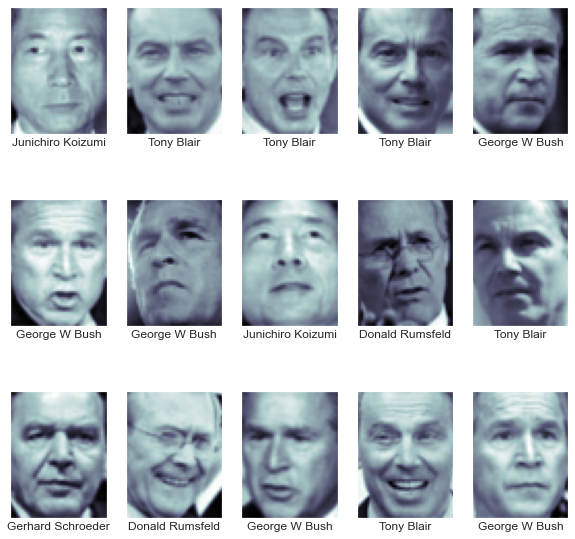

In [11]:
# plot some of these faces to see 
fig, axes = plt.subplots(3, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(faces.images[i], cmap='bone')
    ax.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])   # set multiple attributes 

# 2. Use PCA as feature extractor 

In [12]:
# define model 
pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)

pca.fit(faces.data)

PCA(n_components=150, random_state=42, svd_solver='randomized', whiten=True)

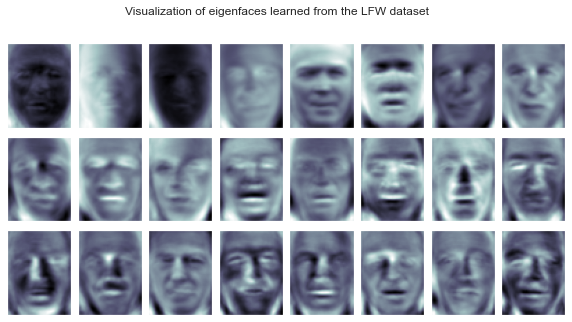

In [13]:
# visualize the images associated with the first several principal components (eigenfaces)
fig, axes = plt.subplots(3, 8, figsize=(10, 5), 
                         subplot_kw={'xticks': [], 'yticks': []}, 
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat): 
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')
plt.suptitle('Visualization of eigenfaces learned from the LFW dataset')
plt.show()

- The first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face. 
- Later principal vectors seem to be picking out certain features, such as eyes, noses, and lips (degree of lighting is the same)

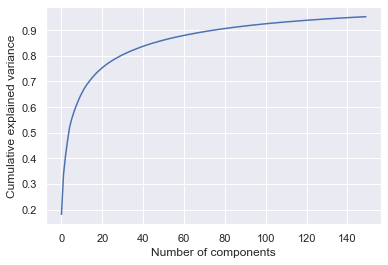

In [14]:
# take a look at cumulative variance of these components 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

We see that these 150 components account for just over 90% of the variance. That
would lead us to believe that using these 150 components, we would recover most of
the essential characteristics of the data.

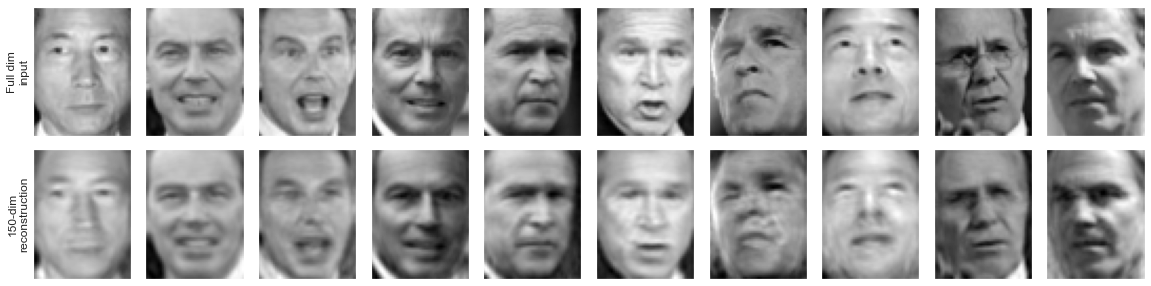

In [15]:
# compare the input images with the images reconstructed from these 150 components 
components = pca.transform(faces.data)            # compute the components  
projected = pca.inverse_transform(components)      # projected faces 

# plot the result 
fig, axes = plt.subplots(2, 10, figsize=(20, 5), 
                         subplot_kw={'xticks': [], 'yticks': []}, 
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(10): 
    axes[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    axes[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
axes[0, 0].set_ylabel('Full dim\ninput')
axes[1, 0].set_ylabel('150-dim\nreconstruction')
plt.show()

# 3. Build the model

In [17]:
# preprocessor 
pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)
# classifier 
svc = SVC(kernel='rbf', class_weight='balanced')

# make pipeline 
model = make_pipeline(pca, svc)

In [21]:
faces.data.shape

(964, 2914)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(723, 2914)
(723,)
(241, 2914)
(241,)


# 4. Cross validation

In [29]:
param_grid = {'svc__C': [1, 5, 10, 50], 
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)
print(grid.best_params_)

CPU times: total: 1min 22s
Wall time: 38.8 s
{'svc__C': 5, 'svc__gamma': 0.005}


# 5. Predict

In [30]:
model = grid.best_estimator_
y_fit = model.predict(X_test)

# 6. Assess the model

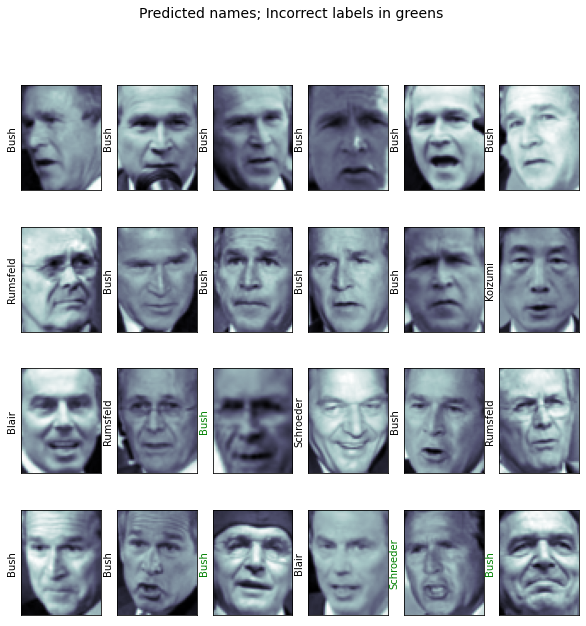

In [37]:
# look at some of the test images with their predicted values 
fig, axes = plt.subplots(4, 6, figsize=(10, 10))

for i, ax in enumerate(axes.flat): 
    ax.imshow(X_test[i].reshape(62, 47), cmap='bone')
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel(faces.target_names[y_fit[i]].split()[-1], 
                  color='black' if y_fit[i] == y_test[i] else 'green')
    
fig.suptitle('Predicted names; Incorrect labels in greens', size=14)
plt.show()

In [39]:
# recovery statistics 
print(classification_report(y_test, y_fit, target_names=faces.target_names))

                   precision    recall  f1-score   support

  Donald Rumsfeld       0.97      0.89      0.93        35
    George W Bush       0.89      0.98      0.93       130
Gerhard Schroeder       0.91      0.77      0.83        26
Junichiro Koizumi       1.00      0.79      0.88        14
       Tony Blair       0.94      0.86      0.90        36

         accuracy                           0.91       241
        macro avg       0.94      0.86      0.89       241
     weighted avg       0.92      0.91      0.91       241



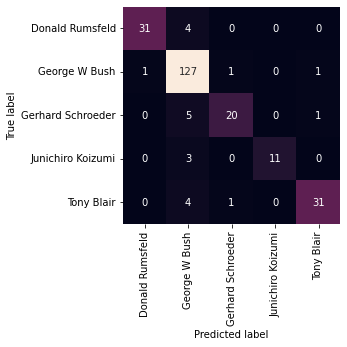

In [43]:
# display confusion matrix 
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=faces.target_names, yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()